Sealevel monitor for regions
========

This document is used to monitor the current sea level along different regions, for example along the Wadden coast . Each region is defined by a number of tide gauges.

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import itertools


# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Loading BokehJS ...

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

In [3]:
psmsl_urls = {
    'met_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
default_dataset_name = 'rlr_annual'

In [4]:
# these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
main_stations = [
    {
        'id': 1,
        'name': 'Brest',
        'regions': ['France']
    },
    {
        'id': 453,
        'name': 'Le Havre',
        'regions': ['France']
    },
    {
        'id': 468,
        'name': 'Dunkerque',
        'regions': ['France']
    },
    {
        'id': 489,
        'name': 'Nieuwpoort',
        'rlr2local': lambda x: x - (7060 - 2384),
        'regions': ['Belgium'],
        'datum': 'TAW'
    },
    {
        'id': 413,
        'name': 'Oostende',
        'rlr2local': lambda x: x - (7000 - 2378),
        'regions': ['Belgium'],
        'datum': 'TAW'       
    },
    {
        'id': 470,
        'name': 'Zeebrugge',
        'rlr2local': lambda x: x - (6965 - 2358),
        'regions': ['Belgium'],
        'datum': 'TAW'
    },
    {
        'id': 20,
        'name': 'Vlissingen', 
        'rlr2local': lambda x: x - (6976-46),
        'alpha': 118,
        'regions': ['Dutch'],
        'datum': 'NAP'
    },
    {
        'id': 22,
        'name': 'Hoek van Holland', 
        'rlr2local': lambda x:x - (6994 - 121),
        'alpha': 117,
        'regions': ['Dutch'],
        'datum': 'NAP'
    },
    {
        'id': 32,
        'name': 'IJmuiden', 
        'rlr2local': lambda x: x - (7033-83),
        'alpha': 110,
        'regions': ['Dutch'],
        'datum': 'NAP'
    },     
    {
        'id': 23,
        'name': 'Den Helder', 
        'rlr2local': lambda x: x - (6988-42),
        'regions': ['Dutch', 'Wadden'],
        'datum': 'NAP'
    },
    {
        'id': 25,
        'name': 'Harlingen', 
        'rlr2local': lambda x: x - (7036-122),
        'regions': ['Dutch', 'Wadden'],
        'datum': 'NAP'
    },
    {
       'id': 24,
        'name': 'Delfzijl', 
        'rlr2local': lambda x: x - (6978-155),
        'regions': ['Dutch', 'Wadden'],
        'datum': 'NAP'
    },
    {
        'id': 1037,
        'name': 'Borkum',
        'rlr2local': lambda x: x - (7025 - (5045 - 5020)),
        'regions': ['German', 'Wadden'],
        'datum': 'Normal Null'
    },
    {
        'id': 7,
        'name': 'Cuxhaven',
        # to Datum 2000- (see PSMSL diagram)
        'rlr2local': lambda x: x - (7154 - (5174 - 5020)),
        'regions': ['German', 'Wadden'],
        'datum': 'NAP'
    },
    {
        'id': 1036,
        'name': 'Amrum',
        'rlr2local': lambda x: x - 7000,
        'regions': ['German', 'Wadden'],
        'datum': 'Normal Null'
    },
    {
        'id': 80,
        'name': 'Esbjerg',
        'regions': ['Denmark', 'Wadden']
    },
    {
        'id': 703,
        'name': 'Hantsholm',
        'regions': ['Denmark']
    },
    {
        'id': 89,
        'name': 'Hirtshals',
        'regions': ['Denmark']
    },
    {
        'id': 302,
        'name': 'Tregde',
        'regions': ['Norway']
    },
    {
        'id': 47,
        'name': 'Stavanger',
        'regions': ['Norway']
    },
    {
        'id': 58,
        'name': 'Bergen',
        'regions': ['Norway']
    },
    {
        'id': 830,
        'name': 'Lerwick',
        'regions': ['United Kingdom']
    },
    {
        'id': 1109,
        'name': 'Wick',
        'regions': ['United Kingdom']
    },
    {
        'id': 361,
        'name': 'Aberdeen',
        'regions': ['United Kingdom']
    },
    {
        'id': 95,
        'name': 'North Shields',
        'regions': ['United Kingdom']
    },
    {
        'id': 754,
        'name': 'Lowestoft',
        'regions': ['United Kingdom']
    },
    {
        'id': 3,
        'name': 'Sheerness', 
        'regions': ['United Kingdom']
    },
    {
        'id': 255,
        'name': 'Dover', 
        'regions': ['United Kingdom']
    },
    {
        'id': 982,
        'name': 'Devonport',
        'regions': ['United Kingdom']
    },
    {
        'id': 202,
        'name': 'Newlyn',
        'regions': ['United Kingdom']
    }
]

In [5]:
# the main stations are defined by their ids
main_stations_df = pd.DataFrame(main_stations).set_index('id')
main_stations_idx = main_stations_df.index.values


In [6]:
# download the zipfile

zipfiles = {}


for dataset_name in psmsl_urls:
    resp = requests.get(psmsl_urls[dataset_name])

    # we can read the zipfile
    stream = io.BytesIO(resp.content)
    zf = zipfile.ZipFile(stream)
    zipfiles[dataset_name] = zf

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zipfiles[dataset_name].read('{}/filelist.txt'.format(dataset_name))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = stations.loc[main_stations_idx].copy()
# set the main stations, this should be a list of 6 stations
selected_stations

,lat,lon,name,coastline_code,station_code,quality
id,,,,,,
1,48.382850,-4.494838,BREST,190,091,N
453,49.481900,0.106000,LE HAVRE,190,051,N
468,51.048091,2.366698,DUNKERQUE,190,001,N
489,51.150000,2.733333,NIEUWPOORT,160,031,N
413,51.233333,2.916667,OOSTENDE,160,021,N
470,51.350000,3.200000,ZEEBRUGGE,160,011,N
20,51.442222,3.596111,VLISSINGEN,150,101,N
22,51.977500,4.120000,HOEK VAN HOLLAND,150,051,N
32,52.462222,4.554722,IJMUIDEN,150,041,N


In [17]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=200, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
tile_provider = bokeh.tile_providers.get_provider(bokeh.tile_providers.Vendors.STAMEN_TERRAIN)
fig.add_tile(tile_provider)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(stations.lon), np.array(stations.lat))
fig.circle(x, y)
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(selected_stations.lon), np.array(selected_stations.lat))
_ = fig.circle(x, y, color='red')


/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_11032/1914391329.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_11032/1914391329.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_11032/1914391329.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(stations.lon), np.array(stations.lat))
/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_11032/1914391329.py:18: FutureWarning: This function is deprecat

In [18]:
# show the plot
bokeh.io.show(fig)

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [19]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
names = {
    'datum': '{dataset_name}/RLR_info/{id}.txt',
    'diagram': '{dataset_name}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'rlr_monthly': '{dataset_name}/data/{id}.rlrdata',
    'rlr_annual': '{dataset_name}/data/{id}.rlrdata',
    'met_monthly': '{dataset_name}/data/{id}.metdata',
    'doc': '{dataset_name}/docu/{id}.txt',
    'contact': '{dataset_name}/docu/{id}_auth.txt'
}

In [20]:
def get_url(station, dataset_name):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    url = names['url'].format(**info)
    return url

for dataset_name in psmsl_urls:
    # fill in the dataset parameter using the global dataset_name
    f = functools.partial(get_url, dataset_name=dataset_name)
    # compute the url for each station
    selected_stations[dataset_name] = selected_stations.apply(f, axis=1)
selected_stations

,lat,lon,name,coastline_code,station_code,quality,met_monthly,rlr_monthly,rlr_annual
id,,,,,,,,,
1,48.382850,-4.494838,BREST,190,091,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
453,49.481900,0.106000,LE HAVRE,190,051,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
468,51.048091,2.366698,DUNKERQUE,190,001,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
489,51.150000,2.733333,NIEUWPOORT,160,031,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
413,51.233333,2.916667,OOSTENDE,160,021,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
470,51.350000,3.200000,ZEEBRUGGE,160,011,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,051,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
32,52.462222,4.554722,IJMUIDEN,150,041,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...


Sea-level explained  
=======


In [21]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def year2date(year_fraction, dtype='datetime64[s]'):
    """convert a fraction of a year + fraction of a year to a date, for example 1993.12 -> 1993-02-01.
    The dtype should be a valid numpy datetime unit, such as datetime64[s]"""
    startpoints = np.linspace(0, 1, num=12, endpoint=False)
    remainder = np.mod(year_fraction, 1)
    year = np.floor_divide(year_fraction, 1).astype('int')
    month = np.searchsorted(startpoints, remainder)
    if (month == 0).all():
        # if month is set to 0 (for annual data), set to january
        month = np.ones_like(month)
    dates = [
        datetime.datetime(year_i, month_i, 1) 
        for year_i, month_i 
        in zip(year, month)
    ]
    datetime64s = np.asarray(dates, dtype=dtype)
    return datetime64s

def get_data(station, dataset_name):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    bytes = zipfiles[dataset_name].read(names[dataset_name].format(**info))
    df = pd.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: missing2nan(x),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    df['t'] = year2date(df.year)
    df = df.set_index('t')
    return df

In [22]:
# get data for all stations
for dataset_name in psmsl_urls:
    f = functools.partial(get_data, dataset_name=dataset_name)
    # look up the data for each station
    selected_stations[dataset_name] = [f(station) for _, station in selected_stations.iterrows()]

Now that we have all data downloaded we can compute the mean.

In [23]:
# compute the mean

grouped = pd.concat(selected_stations[dataset_name].tolist())[['year', 'height']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [24]:
# these are the mean waterlevels 
mean_df.tail()

,year,height
210,2017,7081.958333
211,2018,7023.157895
212,2019,7069.333333
213,2020,7055.500000
214,2021,7039.800000


In [34]:
def timeseries_plot(dataset_name=default_dataset_name):
    # show all the stations, including the mean
    title = 'Sea-surface height for Dutch tide gauges [{year_min} - {year_max}]'.format(
        year_min=mean_df.year.min(),
        year_max=mean_df.year.max() 
    )
    fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
    colors = bokeh.palettes.Accent7
    colors = list(colors)
    # no yellow
    del colors[3]
    for color, (id_, station) in zip(itertools.cycle(colors), selected_stations.iterrows()):
        data = station[dataset_name]
        fig.circle(data.year, data.height, color=color, legend_label=station['name'], alpha=0.5, line_width=1)
    fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend_label='Mean')
    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig


In [35]:
bokeh.io.show(timeseries_plot(default_dataset_name))

In [36]:
bokeh.io.show(timeseries_plot('rlr_monthly'))

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that the selected epoch of 1970 is arbitrary. This model is referred to as `linear_model` in the code. 
$
H(t) = a + b_{trend}(t-1970) + b_u\cos(2\pi\frac{t - 1970}{18.613}) + b_v\sin(2\pi\frac{t - 1970}{18.613}) + e(t - 1970)
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$) and error $e$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$
H(t) = a + b_{trend}(t-1970) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613}) + e(t - 1970)
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$
H(t) = a + b_{trend}(t-1970) + b_{quadratic}(t - 1970)*(t-1970) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613}) + e(t - 1970)
$



In [37]:
# define the statistical model
def linear_model(df, with_season=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_season:
        for i in range(11):
            X = np.c_[
                X,
                np.logical_and(month >= i, month < i+1)
            ]
            names.append('month_%s' % (i+1, ))
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

We can analyse the model.
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [38]:
# first the model without wind
linear_fit, names = linear_model(mean_df, with_season=False)
table = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without wind (1890-current)')
IPython.display.display(table)


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Linear model without wind (1890-current)                   
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     328.8
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           6.08e-60
Time:                        13:21:39   Log-Likelihood:                -611.60
No. Observations:                 132   AIC:                             1231.
Df Residuals:                     128   BIC:                             1243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant    6974.0042      2.356   2960.514      0.000    6969.343    6978.665
Trend          1.8196      0.058     31.343      0.000       1.705       1.934
Nodal U        7.0365      3.146      2.237      0.027       0.811      13.262
Nodal V       -7.1781      3.094     -2.320      0.022     -13.300      -1.056
==============================================================================
Omnibus:                        2.990   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                3.005
Skew:                          -0.356   Prob(JB):                        0.223
Kurtosis:                       2.803   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend_label='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend_label='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [42]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = linear_model(df, with_season=False)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])

    IPython.display.display(smry.tables[1])
    p.circle(station[default_dataset_name].year, station[default_dataset_name].height, alpha=0.1, color=color)
# loop again so we have the lines on top
for color, (name, station) in zip(itertools.cycle(colors), selected_stations.iterrows()):
    df = station[default_dataset_name][station[default_dataset_name].year >= 1890]
    # ignore wind in the plots 
    fit, names = linear_model(df,with_season=False)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend=station['name'],
        color=color
    )
p.legend.click_policy = "hide"

bokeh.io.show(p)


BREST


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,7060.9753,3.179,2221.280,0.000,7054.680,7067.270
Trend,1.6130,0.076,21.140,0.000,1.462,1.764
Nodal U,3.6309,4.235,0.857,0.393,-4.756,12.018
Nodal V,-7.4618,4.198,-1.778,0.078,-15.774,0.851


LE HAVRE


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,7010.2309,7.172,977.379,0.000,6995.817,7024.645
Trend,2.0467,0.228,8.991,0.000,1.589,2.504
Nodal U,-6.8742,7.031,-0.978,0.333,-21.003,7.254
Nodal V,-6.6750,6.993,-0.954,0.345,-20.729,7.379


DUNKERQUE


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,6932.0643,4.794,1445.950,0.000,6922.389,6941.739
Trend,1.7144,0.162,10.590,0.000,1.388,2.041
Nodal U,-4.0021,4.852,-0.825,0.414,-13.794,5.790
Nodal V,-16.6247,5.114,-3.251,0.002,-26.945,-6.304


NIEUWPOORT


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,7043.8734,5.487,1283.764,0.000,7032.853,7054.894
Trend,2.4867,0.200,12.427,0.000,2.085,2.889
Nodal U,-0.9676,4.554,-0.212,0.833,-10.114,8.179
Nodal V,-20.5863,4.794,-4.294,0.000,-30.215,-10.958


OOSTENDE


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,6991.3220,3.221,2170.776,0.000,6984.903,6997.741
Trend,1.8903,0.129,14.643,0.000,1.633,2.148
Nodal U,-1.6941,4.185,-0.405,0.687,-10.035,6.647
Nodal V,-11.7245,4.073,-2.878,0.005,-19.843,-3.606


ZEEBRUGGE


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,6960.6931,5.847,1190.371,0.000,6948.954,6972.432
Trend,2.8794,0.226,12.743,0.000,2.426,3.333
Nodal U,0.6325,5.207,0.121,0.904,-9.820,11.085
Nodal V,-15.0126,5.317,-2.823,0.007,-25.688,-4.338


In [43]:
fit.model.exog[:, 1]

array([-54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44.,
       -43., -42., -41., -40., -39., -38., -37., -36., -35., -34., -33.,
       -32., -31., -30., -29., -28., -27., -26., -25., -24., -23., -22.,
       -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
       -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  38.,  39.,  41.,  42.,  43.,  44.,  46.,  47.,
        48.,  49.])

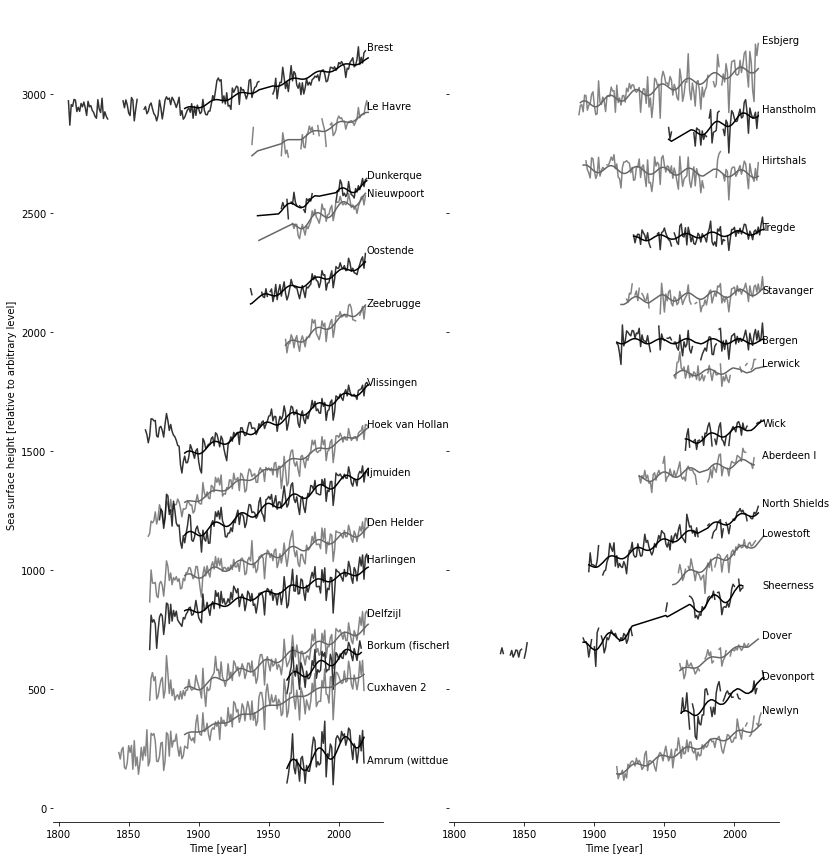

In [44]:
import matplotlib.pyplot as plt

def camelize(text):
    return ' '.join((x.lower() if x.lower() in ('de', 'van') else x.capitalize()) for x in text.split())

fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13, 15))

n_per_col = selected_stations.shape[0] // 2 

fits = []
for i, color, (name, station), ax in zip(
    list(range(n_per_col)) * 2,
    itertools.cycle([(0, 0, 0), (0.4, 0.4, 0.4)]), 
    selected_stations.iterrows(), 
    [axes[0]]*n_per_col + [axes[1]] * n_per_col
):
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = linear_model(df, with_season=False)
    fits.append({
        'station': station,
        'fit': fit
    })
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    ax.plot(
        station[default_dataset_name].year, 
        station[default_dataset_name].height - 4000 - i * 200, 
        alpha=0.8, 
        color=color
    )
    ax.plot(fit.model.exog[:, 1] + 1970, fit.predict() - 4000 - i* 200, '-', 
        color=color)
    ax.annotate(camelize(station['name']), (2020, station[default_dataset_name].height[-1] - 4000 - i * 200))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('Time [year]')
axes[0].set_ylabel('Sea surface height [relative to arbitrary level]')
fig.savefig('multiple-stations.pdf')

In [ ]:
import seaborn as sns

y = np.array([fit['fit'].params[1] for fit in fits])
sns.distplot(y, rug=True, bins=[-1, 0, 1, 1.333, 1.667, 2, 2.3333, 2.66667, 3, 4])

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [ ]:
# define the statistical model
def broken_linear_model(df):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1990) * (df['year'] - 1990),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_broken_linear = sm.OLS(y, X)
    fit = model_broken_linear.fit()
    return fit
broken_linear_fit = broken_linear_model(mean_df)

In [ ]:
# define the statistical model
def quadratic_model(df):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_quadratic = sm.OLS(y, X)
    fit = model_quadratic.fit()
    return fit
quadratic_fit = quadratic_model(mean_df)

In [ ]:
# summary of the broken linear model
broken_linear_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend(year > 1990)', 'Nodal U', 'Nodal V'])


In [ ]:
# summary of the quadratic model
quadratic_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend**2', 'Nodal U', 'Nodal V'])


In [ ]:
def model_compare_plot():
    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=300)
    fig.circle(mean_df.year, mean_df.height, line_width=3, legend='Mean', color='black', alpha=0.5)
    fig.line(mean_df.year, linear_fit.predict(), line_width=3, legend='Current')
    fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color='#33bb33', legend='Broken')
    fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color='#3333bb', legend='Quadratic')

    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig

bokeh.io.show(model_compare_plot())

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [ ]:
msg = '''The current average waterlevel above NAP (in mm), 
based on the  tide gauges for the year {year} is {height:.1f} cm.
The current sea-level rise is {rate:.0f} cm/century'''
print(msg.format(year=mean_df['year'].iloc[-1], height=linear_fit.predict()[-1]/10.0, rate=linear_fit.params.x1*100.0/10))

In [ ]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

In [ ]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')